In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
%matplotlib inline

## Camera Calliberation

In [2]:
def calibrate_camera(images, nx, ny):
    obj_points = [] #3d real world points
    img_points = [] #2d points on image plane
    
    obj_p = np.zeros((ny*nx,3),np.float32)
    obj_p[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y co-ordinates 
    
    img_size = (1280, 720)
    
    for frame in tqdm(images): 
        #read the images
        img = cv2.imread(frame)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to gray scale
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #find the corners
        
        if ret:
            img_points.append(corners)
            obj_points.append(obj_p)
            
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    
    return mtx, dist
            
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = calibrate_camera(images,9,6)

100%|██████████| 20/20 [00:09<00:00,  1.11it/s]


## Undistort Image

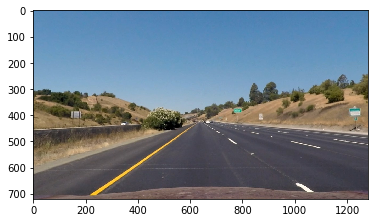

In [4]:
img = mpimg.imread("test_images/straight_lines1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(dst)

## ROI

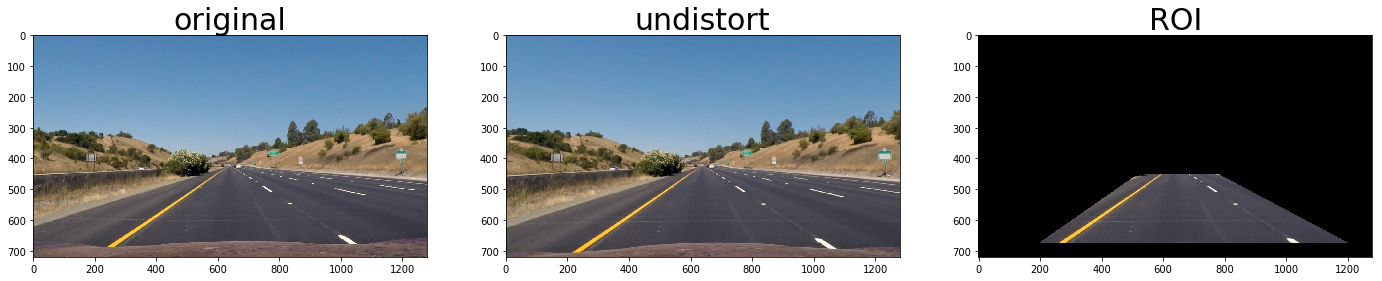

In [5]:
left_bottom = (200, 672)
left_top = (520, 450)
right_bottom = (1200, 672)
right_top = (780, 450)
roi_points = [[left_top, right_top, right_bottom, left_bottom]]

def region_of_interest(img, roi_points):
    mask = np.zeros_like(img)
    vertices = np.array(roi_points, dtype=np.int32)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread("test_images/straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)


f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
axs[1].imshow(undist), axs[1].set_title('undistort', fontsize=30)
axs[2].imshow(roi), axs[2].set_title('ROI', fontsize=30)

## Perspective transform

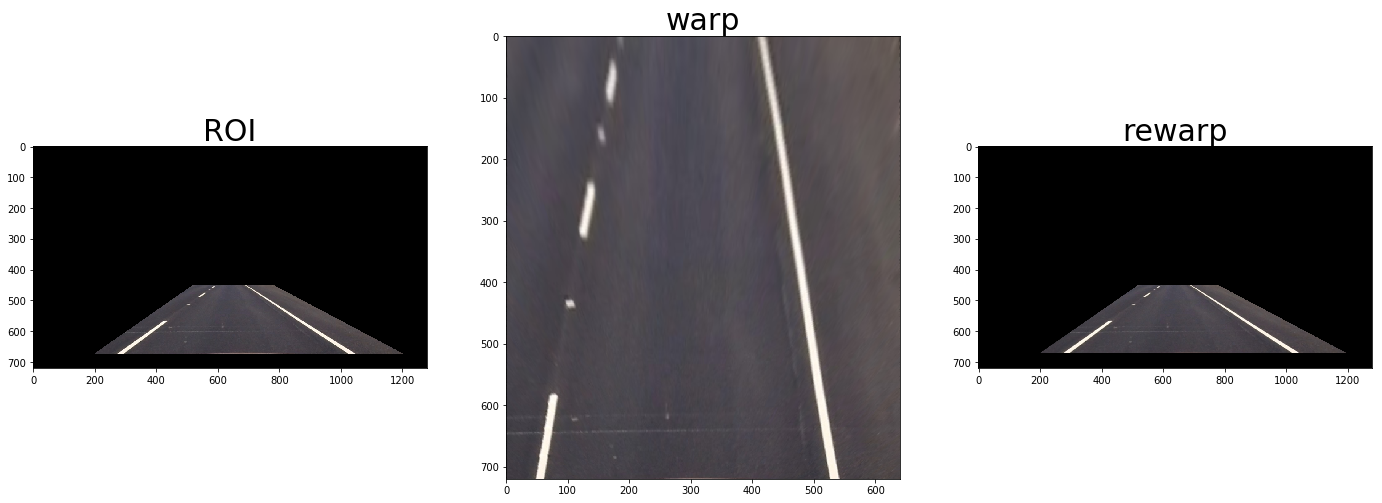

In [6]:
def warp(img, roi_vertices):
    img_size = (640,720)
    #co-ordinates
    src = np.float32(roi_vertices) #source co-ordinates
    dst = np.float32([[0,0],[640,0],[640,720],[0,720]]) #dest co-cordinates
    #Compute the perspective transformation
    M = cv2.getPerspectiveTransform(src, dst)
    #Warp image
    warped_img = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped_img

def un_warp(img, roi_vertices):
    img_size = (1280,720)
    #co-ordinates
    dst = np.float32(roi_vertices) #destination co-ordinates
    src = np.float32([[0,0],[640,0],[640,720],[0,720]]) #source co-cordinates
    #Compute the perspective transformation
    M = cv2.getPerspectiveTransform(src, dst)
    #Warp image
    rewarped_img = cv2.warpPerspective(img,M,img_size,flags=cv2.INTER_LINEAR)
    
    return rewarped_img


img = mpimg.imread("test_images/straight_lines2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
rewarped = un_warp(warped, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(roi, cmap='gray'), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('warp', fontsize=30)
axs[2].imshow(rewarped, cmap='gray'), axs[2].set_title('rewarp', fontsize=30)
    

# Binary Calcs
## Sobel

(<matplotlib.image.AxesImage at 0x7fc624068c50>, Text(0.5,1,'Y'))

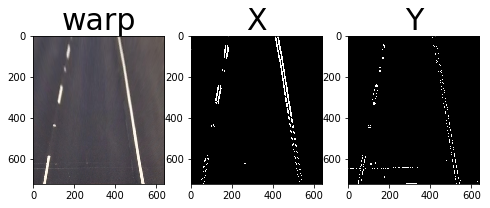

In [8]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #covert to gray scale
    if orient == 'x': #if finding sobelx
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y': #if finding sobely
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

img = mpimg.imread("test_images/straight_lines2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
sxbinary = abs_sobel_thresh(warped, 'x', 9, (30, 100))
sybinary = abs_sobel_thresh(warped, 'y', 9, (30, 100))

f, axs = plt.subplots(1, 3, figsize=(8, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=30)
axs[1].imshow(sxbinary, cmap='gray'), axs[1].set_title('X', fontsize=30)
axs[2].imshow(sybinary, cmap='gray'), axs[2].set_title('Y', fontsize=30)


## Magnitude 

Text(0.5,1,'magnitude binary')

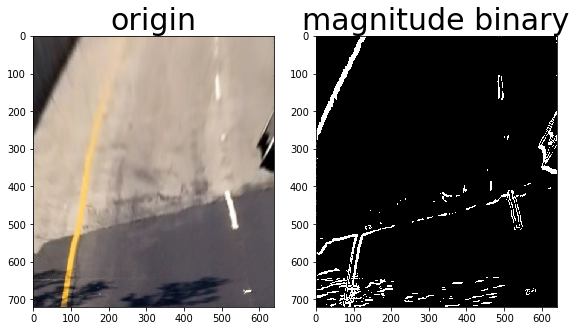

In [9]:
def mag_thresh(img, sobel_kernel, mag_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

img = mpimg.imread("test_images/test4.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
mag_binary = mag_thresh(warped, 9, (30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('origin', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('magnitude binary', fontsize=30)

## Direction

Text(0.5,1,'direction binary')

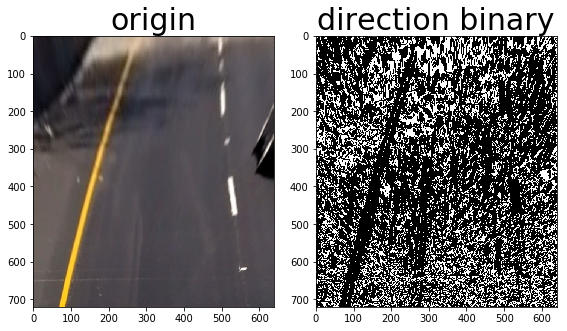

In [10]:
def dir_thresh(img, sobel_kernel, thresh):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


img = mpimg.imread("test_images/test6.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
dir_binary = dir_thresh(warped, 15, (0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('origin', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('direction binary', fontsize=30)

## Combine Gradient

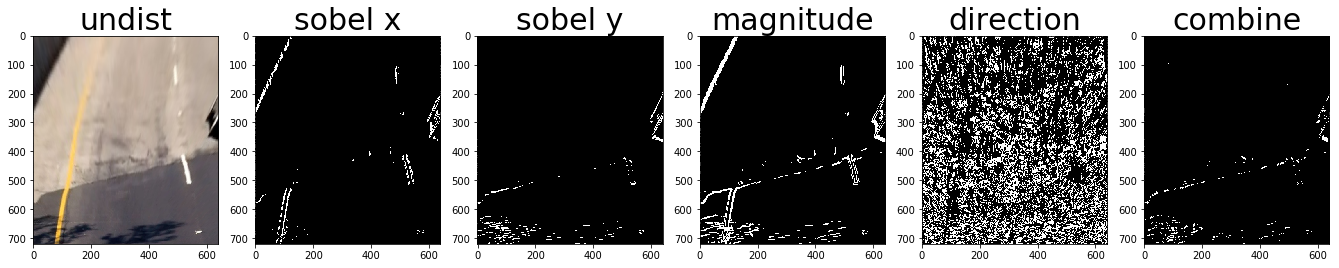

In [11]:
img = mpimg.imread("test_images/test4.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
sx_binary = abs_sobel_thresh(warped, 'x', 9, (30, 100))
sy_binary = abs_sobel_thresh(warped, 'y', 9, (30, 100))
mag_binary = mag_thresh(warped, 9, (30, 100))
dir_binary = dir_thresh(warped, 15, (0.7, 1.3))
combined = np.zeros_like(dir_binary)
# threshold of x,y gradient or magnitude and direction
combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, axs = plt.subplots(1, 6, figsize=(18, 9))
axs[0].imshow(warped), axs[0].set_title('undist', fontsize=30)
axs[1].imshow(sx_binary, cmap='gray') ,axs[1].set_title('sobel x', fontsize=30)
axs[2].imshow(sy_binary, cmap='gray'), axs[2].set_title('sobel y', fontsize=30)
axs[3].imshow(mag_binary, cmap='gray'), axs[3].set_title('magnitude', fontsize=30)
axs[4].imshow(dir_binary, cmap='gray'), axs[4].set_title('direction', fontsize=30)
axs[5].imshow(combined, cmap='gray'), axs[5].set_title('combine', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

## Color space: RGB

(<matplotlib.image.AxesImage at 0x7fc624bfb048>, Text(0.5,1,'B binary'))

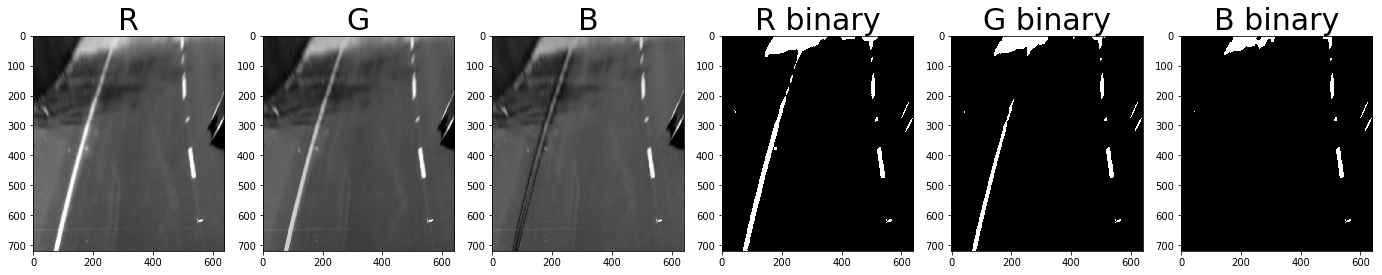

In [12]:
def rgb_thresh(img, channel, thresh):
    channel = img[:,:,channel]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0])&(channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/test6.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
R = warped[:,:,0]
G = warped[:,:,1]
B = warped[:,:,2]
r_binary = rgb_thresh(warped, 0, (150, 255))
g_binary = rgb_thresh(warped, 1, (150, 255))
b_binary = rgb_thresh(warped, 2, (150, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(R, cmap='gray') ,axs[0].set_title('R', fontsize=30)
axs[1].imshow(G, cmap='gray'), axs[1].set_title('G', fontsize=30)
axs[2].imshow(B, cmap='gray'), axs[2].set_title('B', fontsize=30)
axs[3].imshow(r_binary, cmap='gray') ,axs[3].set_title('R binary', fontsize=30)
axs[4].imshow(g_binary, cmap='gray'), axs[4].set_title('G binary', fontsize=30)
axs[5].imshow(b_binary, cmap='gray'), axs[5].set_title('B binary', fontsize=30)

## Color Space: HLS

(<matplotlib.image.AxesImage at 0x7fc61f35ba58>, Text(0.5,1,'S binary'))

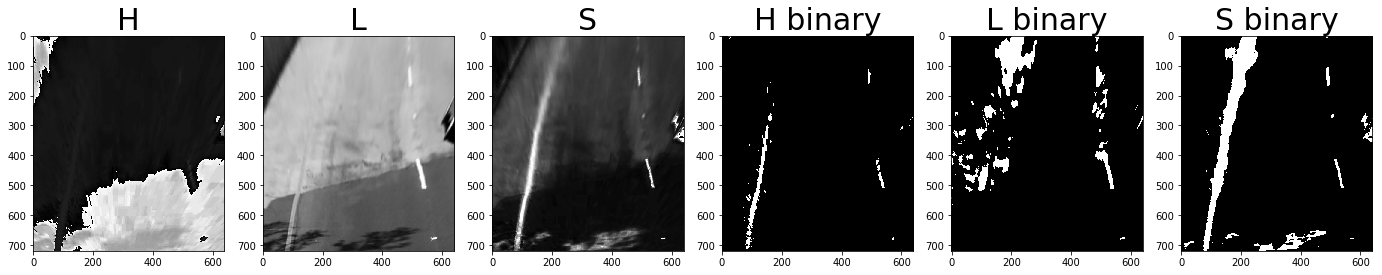

In [13]:
def hls_thresh(img, channel, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0])&(channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/test4.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
H_binary = hls_thresh(warped, 0, (19, 50))
L_binary = hls_thresh(warped, 1, (195, 255))
S_binary = hls_thresh(warped, 2, (90, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(H, cmap='gray') ,axs[0].set_title('H', fontsize=30)
axs[1].imshow(L, cmap='gray'), axs[1].set_title('L', fontsize=30)
axs[2].imshow(S, cmap='gray'), axs[2].set_title('S', fontsize=30)
axs[3].imshow(H_binary, cmap='gray') ,axs[3].set_title('H binary', fontsize=30)
axs[4].imshow(L_binary, cmap='gray'), axs[4].set_title('L binary', fontsize=30)
axs[5].imshow(S_binary, cmap='gray'), axs[5].set_title('S binary', fontsize=30)

## Color Gradient Combine

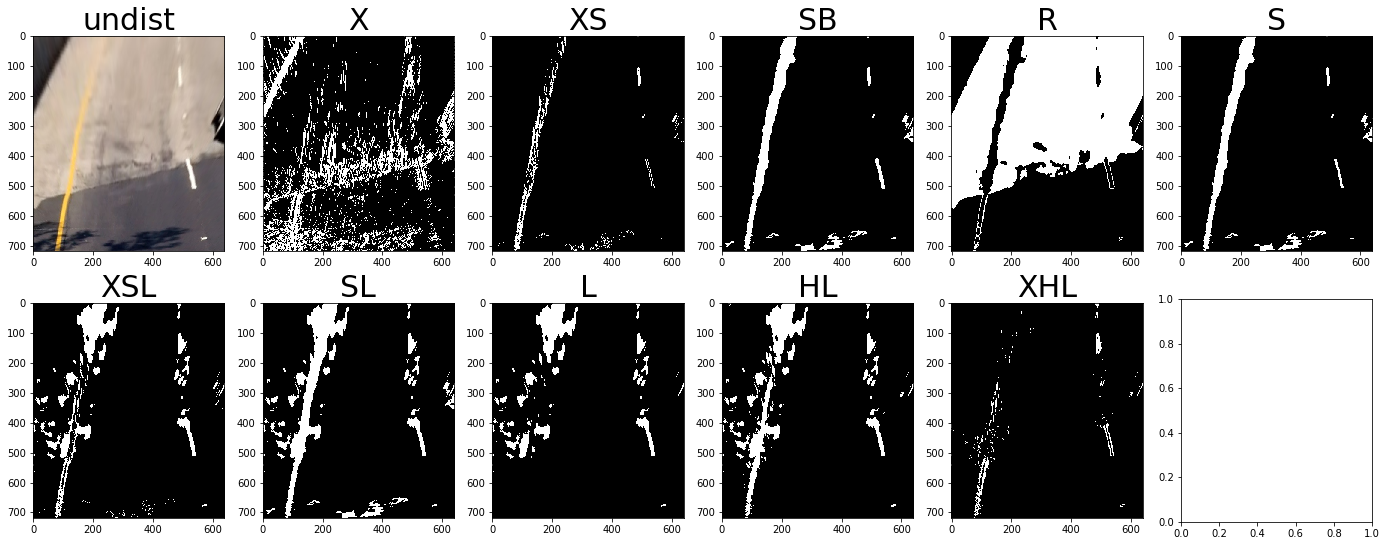

In [20]:
# combine sobel x and saturatioin
def xs_thresh(img, x_thresh, s_thresh):
    sxbinary = abs_sobel_thresh(img, 'x', 3, x_thresh)
#     sxbinary = cv2.erode(img, (5,5), iterations=1)
    s_binary = hls_thresh(img, 2, s_thresh)

    xs_binary = np.zeros_like(sxbinary)
    xs_binary[(sxbinary == 1) & (s_binary == 1)] = 1

    return xs_binary

# combine saturation or blue
def sb_thresh(img, s_thresh, b_thresh):    
    s_binary = hls_thresh(img, 2, s_thresh)
    b_binary = rgb_thresh(img, 2, b_thresh)
    sb_binary = np.zeros_like(sxbinary)
    sb_binary[(b_binary == 1) | (s_binary == 1)] = 1
    return sb_binary

def sl_thresh(img, s_thresh, l_thresh):
    l_binary = hls_thresh(img, 1, l_thresh)
    s_binary = hls_thresh(img, 2, s_thresh)
    
    sl_binary = np.zeros_like(s_binary)
    sl_binary[(s_binary == 1) | (l_binary == 1)] = 1
    
    return sl_binary

def xsl_thresh(img, x_thresh, s_thresh, l_thresh):
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    s_binary = hls_thresh(img, 2, s_thresh)

    xs_binary = np.zeros_like(sxbinary)
    xs_binary[(sxbinary == 1) & (s_binary == 1)] = 1
    
    l_binary = hls_thresh(img, 1, l_thresh)
    xsl_binary = np.zeros_like(xs_binary)
    xsl_binary[(xs_binary == 1) | (l_binary == 1)] = 1
    
    return xsl_binary

def hl_thresh(img, h_thresh, l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l > l_thresh[0]) & (l <= l_thresh[1])] = 1
    hl_binary = np.zeros_like(l)
    hl_binary[(h_binary == 1) | (l_binary == 1)] = 1
    return hl_binary

def xhl_thresh(img, x_thresh, h_thresh, l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l > l_thresh[0]) & (l <= l_thresh[1])] = 1
    hl_binary = np.zeros_like(l)
    hl_binary[(h_binary == 1) | (l_binary == 1)] = 1
    
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    xhl_binary = np.zeros_like(sxbinary)
    xhl_binary[(hl_binary == 1) & (sxbinary == 1)] = 1
    
    return xhl_binary

img = mpimg.imread("test_images/test4.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
l_binary = hls_thresh(warped, 1, (195, 255))
x_binary = abs_sobel_thresh(warped, 'x', 5, (5, 100))
xs_binary = xs_thresh(warped, (3, 200), (100, 255))
sb_binary = sb_thresh(warped, (100, 255), (200, 255))
r_binary = rgb_thresh(warped, 0, (150, 220))
sl_binary = sl_thresh(warped, (100, 255), (195, 255))
s_binary = hls_thresh(warped, 2, (100, 255))
xsl_binary = xsl_thresh(warped, (5, 200), (100, 255), (195, 255))
hl_binary = hl_thresh(warped, (18, 50), (195, 255))
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))

f, axs = plt.subplots(2, 6, figsize=(24, 9))
axs[0,0].imshow(warped), axs[0,0].set_title('undist', fontsize=30)
axs[0,1].imshow(x_binary, cmap='gray'), axs[0,1].set_title('X', fontsize=30)
axs[0,2].imshow(xs_binary, cmap='gray'), axs[0,2].set_title('XS', fontsize=30)
axs[0,3].imshow(sb_binary, cmap='gray'), axs[0,3].set_title('SB', fontsize=30)
axs[0,4].imshow(r_binary, cmap='gray'), axs[0,4].set_title('R', fontsize=30)
axs[0,5].imshow(s_binary, cmap='gray'), axs[0,5].set_title('S', fontsize=30)
axs[1,0].imshow(xsl_binary, cmap='gray'), axs[1,0].set_title('XSL', fontsize=30)
axs[1,1].imshow(sl_binary, cmap='gray'), axs[1,1].set_title('SL', fontsize=30)
axs[1,2].imshow(l_binary, cmap='gray'), axs[1,2].set_title('L', fontsize=30)
axs[1,3].imshow(hl_binary, cmap='gray'), axs[1,3].set_title('HL', fontsize=30)
axs[1,4].imshow(xhl_binary, cmap='gray'), axs[1,4].set_title('XHL', fontsize=30)

## Histogram
###### Going with XS as it looks the most reliable

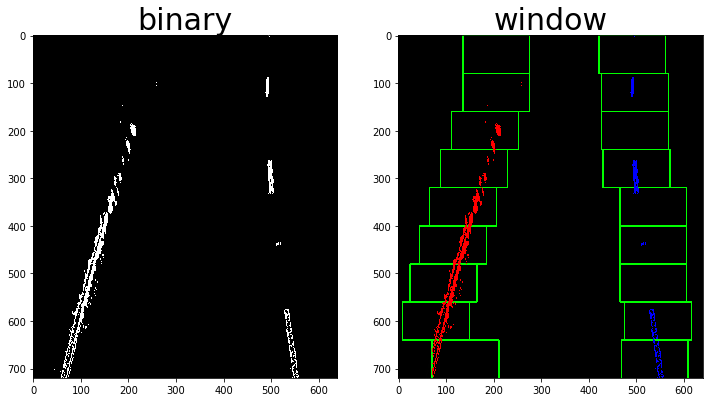

In [15]:
def nonzero(warped):
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

def sliding_windows(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    nonzerox, nonzeroy = nonzero(warped)
    
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    # the number of sliding windows
    nwindows = 9
    # set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # current positions to be updated for each window
    left_current = left_base
    right_current = right_base
    # set with width of the windows +/- margin
    margin = 70
    # set minimum number of pixels found to recenter window
    minpix = 50
    # create empty lists to receive left and right lane pixel indices
    left_inds = []
    right_inds = []

    # step through the windows one by one
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_low = warped.shape[0] - (window + 1) * window_height
        win_high = warped.shape[0]- window * window_height
        win_left_left = left_current - margin
        win_left_right = left_current + margin
        win_right_left = right_current - margin
        win_right_right = right_current + margin
        # draw the windows on the visualization image
        cv2.rectangle(out, (win_left_left, win_low), (win_left_right, win_high), (0, 255, 0), 2)
        cv2.rectangle(out, (win_right_left, win_low), (win_right_right, win_high), (0, 255, 0), 2)
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_left_left) & (nonzerox < win_left_right)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_right_left) & (nonzerox < win_right_right)).nonzero()[0]
        # append these indices in this window to the list of all windows
        left_inds.append(good_left_inds)
        right_inds.append(good_right_inds)
        # if you found > minpix pixels, recenter next window on theri mean position
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
                   
    # concatenate all the arrays of indices
    left_inds = np.concatenate(left_inds)  
    right_inds = np.concatenate(right_inds)
    
    # draw left and right lane lines     
    out[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
    out[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
    
    return [left_inds, right_inds]

img = mpimg.imread("test_images/test3.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
out = np.dstack((xhl_binary, xhl_binary, xhl_binary)) ** 255
indices = sliding_windows(xhl_binary)
        
f, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(xhl_binary, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].imshow(out), axs[1].set_title('window', fontsize=30)

## Polynomial Fit

[array([  1.72766062e-04,  -3.33773383e-01,   2.36405343e+02]), array([  1.90262823e-04,  -7.25131462e-03,   4.88042924e+02])]


(<matplotlib.image.AxesImage at 0x7fc61f5abf98>, Text(0.5,1,'warp'))

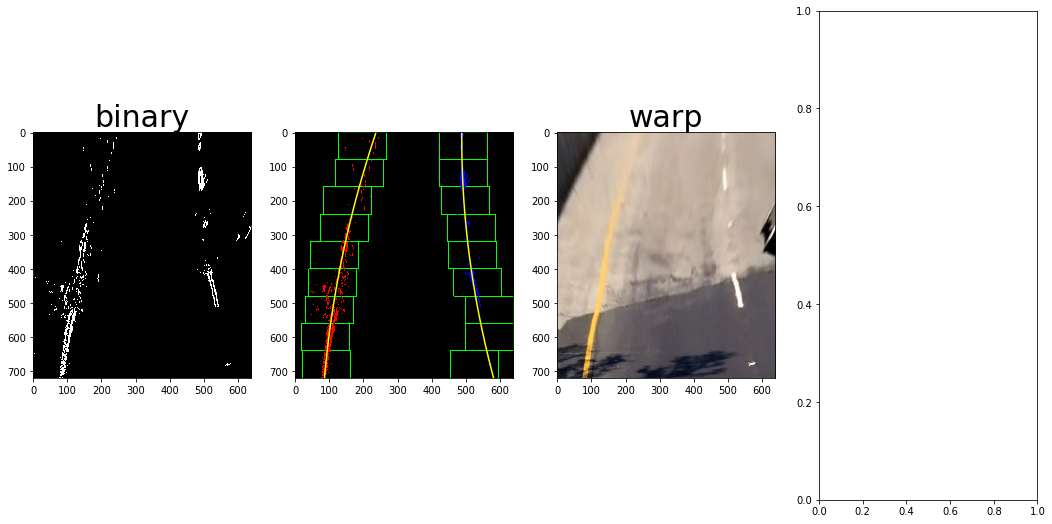

In [16]:
def fit_polynomial(warped, indices, polynomial):
    # divide left and right indices
    left_inds = indices[0]
    right_inds = indices[1]
    
    if (len(left_inds)==0 | len(right_inds)==0):
        return polynomial
    
    nonzerox, nonzeroy = nonzero(warped)
    
    # extract x and y of lane line pixel by indices
    leftx = nonzerox[left_inds]
    lefty = nonzeroy[left_inds]
    rightx = nonzerox[right_inds]
    righty = nonzeroy[right_inds]

    # fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if((polynomial != []) & (left_fit[0] * right_fit[0] < 0.)):
        if(np.absolute(left_fit[1] - polynomial[0][1]) > 0.1):
            left_fit[0] = right_fit[0]
            left_fit[1] = right_fit[1]
            left_fit[2] = right_fit[2] - 450
        if(np.absolute(right_fit[1] - polynomial[1][1]) > 0.1):
            right_fit[0] = left_fit[0]
            right_fit[1] = left_fit[1]
            right_fit[2] = left_fit[2] + 450
    
#     print(left_fit, polynomial)
#     if((polynomial != []) & (np.absolute(left_fit[2] - polynomial[0][2]) > 60)):
#         left_fit = polynomial[0]
    
    return [left_fit, right_fit]

# generate x and y values for plotting
def calculate_lane(polynomial):
    left_poly = polynomial[0]
    right_poly = polynomial[1]
    ploty = np.linspace(0, 719, 720)
    left_fitx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2] 
    right_fitx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
    return [left_fitx, right_fitx]
    
img = mpimg.imread("test_images/test4.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (4, 100), (18, 50), (195, 255))
out = np.dstack((xhl_binary, xhl_binary, xhl_binary)) ** 255
indices = sliding_windows(xhl_binary)
polynomial = fit_polynomial(xhl_binary, indices, [])
print(polynomial)
laneline = calculate_lane(polynomial)
ploty = np.linspace(0, 719, 720)

f, axs = plt.subplots(1, 4, figsize=(18, 9))
axs[0].imshow(xhl_binary, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].imshow(out), axs[2].set_title('out', fontsize=30)
axs[1].plot(laneline[0], ploty, color='yellow'), axs[1].plot(laneline[1], ploty, color='yellow')
axs[2].imshow(warped), axs[2].set_title('warp', fontsize=30)

## Tuning Windows

[array([  6.90514740e-05,  -3.38593455e-01,   2.73016627e+02]), array([  1.45031256e-04,  -1.70877683e-02,   4.91087564e+02])]


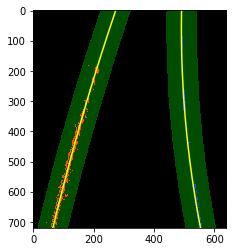

In [17]:
# tuning windows around the sliding windows or previous tuning windows
def tuning_windows(polynomial, warped_binary):
    left_poly = polynomial[0]
    right_poly = polynomial[1]
    ploty = np.linspace(0, 719, 720)
    nonzerox, nonzeroy = nonzero(warped_binary)  
    margin = 100

    # using pervious fit of polynomial to perdict the position of indices of lane line
    left_pre = left_poly[0] * nonzeroy ** 2 + left_poly[1] * nonzeroy + left_poly[2]
    right_pre = right_poly[0] * nonzeroy ** 2 + right_poly[1] * nonzeroy + right_poly[2]
    
    # find indices position in warp between prediction +/- margin
    left_inds = ((nonzerox > left_pre - margin) & (nonzerox < left_pre + margin))
    right_inds = ((nonzerox > right_pre - margin) & (nonzerox < right_pre + margin))
    
    return [left_inds, right_inds]

def tuning_draw(laneline, indices, warped_binary):
    left_fitx = laneline[0]
    right_fitx = laneline[1]
    ploty = np.linspace(0, 719, 720)
    nonzerox, nonzeroy = nonzero(warped_binary)  
    # create an image to draw on and an image to show the selection window
    out = np.dstack((warped_binary, warped_binary, warped_binary)) ** 255
    window = np.zeros_like(out)

    margin = 50
    # generate a polygon to illustrate the search window area and recast the x and y points into usable format for cv2.fillPoly()
    left_window1 = np.array([np.transpose(np.vstack([laneline[0] - margin, ploty]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([laneline[0] + margin, ploty])))])
    left_pts = np.hstack((left_window1, left_window2))
    right_window1 = np.array([np.transpose(np.vstack([laneline[1] - margin, ploty]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([laneline[1] + margin, ploty])))])
    right_pts = np.hstack((right_window1, right_window2))

    # color in left and right line pixels
    out[nonzeroy[indices[0]], nonzerox[indices[0]]] = [255, 0, 0]
    out[nonzeroy[indices[1]], nonzerox[indices[1]]] = [0, 0, 255]

    # draw the lane onto the warped blank image
    cv2.fillPoly(window, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(window, np.int_([right_pts]), (0, 255, 0))
    result = cv2.addWeighted(out, 1, window, 0.3, 0)
    
    return result


# the next frame of the video 
img = mpimg.imread("test_images/test3.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
indices = tuning_windows(polynomial, xhl_binary)
polynomial_new = fit_polynomial(xhl_binary, indices, [])
print(polynomial_new)
laneline = calculate_lane(polynomial_new)
result = tuning_draw(laneline, indices, xhl_binary)


plt.imshow(result)
plt.plot(laneline[0], ploty, color='yellow')
plt.plot(laneline[1], ploty, color='yellow')

## Curvature

In [18]:
# conversions in x and y from pixels space to meters
def curvature_meter(polynomial, ym, xm, y_eval):
    left_fit = polynomial[0]
    right_fit = polynomial[1]
    
    # pixel function to meter function
    l_A = left_fit[0] * xm / (ym ** 2)
    l_B = left_fit[1] * xm / ym
    
    # pixel function to meter function
    r_A = right_fit[0] * xm / (ym ** 2)
    r_B = right_fit[1] * xm / ym

    # calculate the new radius of curvature
    left_curcerad = ((1 + (2 * l_A * y_eval * ym + l_B) ** 2) ** 1.5) / np.absolute(2 * l_A)
    right_curcerad = ((1 + (2 * r_A * y_eval * ym + r_B) ** 2) ** 1.5) / np.absolute(2 * r_A)
    return left_curcerad, right_curcerad

## Rewarp

[array([  1.72588654e-04,  -3.32528451e-01,   2.36004555e+02]), array([  1.77201853e-04,   2.07265043e-03,   4.87211747e+02])]


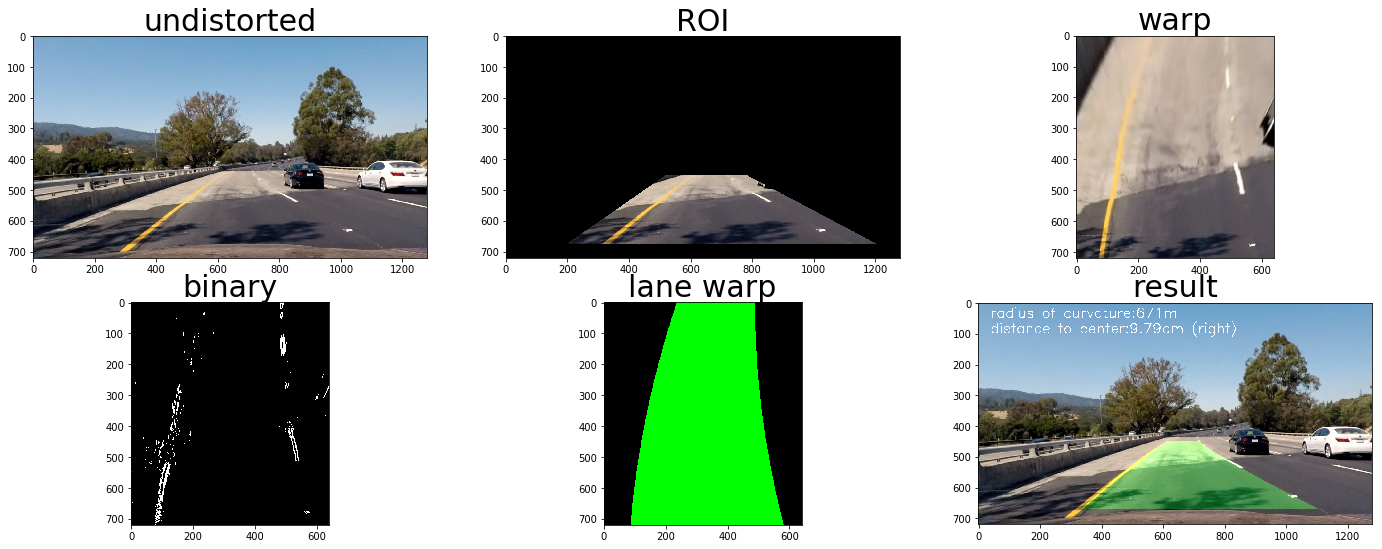

In [19]:
def warp_lane(warped, laneline):
    # create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    lane_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, 720)
    left_pts = np.array([np.transpose(np.vstack([laneline[0], ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([laneline[1], ploty])))])
    pts = np.hstack((left_pts, right_pts))

    # draw the lane onto the warped blank image
    cv2.fillPoly(lane_warp, np.int_([pts]), (0, 255, 0))
    
    return lane_warp

def curvature_distance(laneline, polynomial):
    left_curcerad, right_curcerad = curvature_meter(polynomial, 30 / 720, 3.7 / 500, 720)
    curvature = int((left_curcerad + right_curcerad) / 2)
    distance = round(((laneline[0][-1] + laneline[1][-1]) / 2 - 320) * 3.7 / 5, 2)
    
    return curvature, distance

def draw_result(undist, lane_warp, roi_points, curvature, distance):
    # warp the blank back to original image space using inverse perspective matrix
    rewarped = un_warp(lane_warp, roi_points)
    result = cv2.addWeighted(undist, 1, rewarped, 0.3, 0)
    result = cv2.putText(result, 'radius of curvature:' + str(curvature) + 'm', (40, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    if (distance > 0):
        result = cv2.putText(result, 'distance to center:' + str(distance) + 'cm ' + '(right)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    else:
        result = cv2.putText(result, 'distance to center:' + str(-distance) + 'cm ' + '(left)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    return result

img = mpimg.imread("test_images/test4.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(undist, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
# sl_binary = sl_thresh(warped, (100, 255), (200, 255))
indices = sliding_windows(xhl_binary)
polynomial = fit_polynomial(xhl_binary, indices, [])
print(polynomial)
laneline = calculate_lane(polynomial)
curvature, distance = curvature_distance(laneline, polynomial)
lane_warp = warp_lane(xhl_binary, laneline)
result = draw_result(undist, lane_warp, roi_points, curvature, distance)


f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0,0].imshow(undist), axs[0,0].set_title('undistorted', fontsize=30)
axs[0,1].imshow(roi), axs[0,1].set_title('ROI', fontsize=30)
axs[0,2].imshow(warped), axs[0,2].set_title('warp', fontsize=30)
axs[1,0].imshow(xhl_binary, cmap='gray'), axs[1,0].set_title('binary', fontsize=30)
axs[1,1].imshow(lane_warp), axs[1,1].set_title('lane warp', fontsize=30)
axs[1,2].imshow(result), axs[1,2].set_title('result', fontsize=30)

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [55]:
def process_image(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    roi = region_of_interest(undist, roi_points)
    warped = warp(undist, roi_points)
    xhl_binary = xhl_thresh(warped, (3, 200), (18, 50), (195, 255))
    indices = sliding_windows(xhl_binary)
    polynomial = fit_polynomial(xhl_binary, indices, [])
    laneline = calculate_lane(polynomial)
    curvature, distance = curvature_distance(laneline, polynomial)
    lane_warp = warp_lane(xhl_binary, laneline)
    result = draw_result(undist, lane_warp, roi_points, curvature, distance)

    return result

In [58]:
white_output = 'output_images/project_video_xhl_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
##clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_xhl_output.mp4
[MoviePy] Writing video output_images/project_video_xhl_output.mp4


100%|█████████▉| 1260/1261 [03:26<00:00,  6.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_xhl_output.mp4 



In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))